# Novel Adversarial Attacks

## Setup
The next block prints GPU info. Make sure your GPU RAM is at least 16GB. Otherwise some code might run out of GPU RAM.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug 26 16:07:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Mount the Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**CAUTION**: one should modify the next block to accomodate their own Google Drive directory structure. This Colab Notebook would only work if the accompanying data are positioned in the right place. The structure of your project folder shoud be
```
<project folder>
---> <this notebook>
---> <data> # where CIFAR10 and CIFAR100 as well as adversarial data are stored
---> <save> # where the trained models are stored
---> ---> <cifar10.pt> # trained CIFAR10 model
---> ---> <cifar100.pt> # trained CIFAR100 model
---> ---> <adv10.pt> adversarially fine-tuned CIFAR10 model
---> ---> <adv10.pt> adversarially fine-tuned CIFAR10 model
```

After one mounts the Google Drive, one should run (next block)
a terminal command with the format: `%cd /PATH_TO_PROJECT_FOLDER`

In [3]:
# CAUTION: one should modify this line of code to accomodate their own Google Drive directory structure
# Command format: %cd /PATH_TO_
%cd /content/drive/My\ Drive/Colab\ Notebooks/MLSS/final_project

/content/drive/My Drive/Colab Notebooks/MLSS/final_project


Import packages

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from PIL import Image
import json
import cv2
import imageio

Define the device on which the computation is done. If CUDA is available, use CUDA. Otherwise, use CPU.

In [5]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print(DEVICE)

cuda


Next we port and modify some functions from Dan Hendryck's example Colab Notebook to help us visualize our adversarial attacks

In [6]:
cifar10_classes = classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
round_float = lambda x : round(x,3)

def visualise_attack(model, attack, inputs, targets):

  inputs,targets = inputs.to(DEVICE),targets.to(DEVICE)

  standard_outputs = model(inputs)
  standard_probs = torch.softmax(standard_outputs,dim=1)
  standard_loss = F.cross_entropy(standard_outputs,targets,reduction="none")
  standard_classes = torch.argmax(standard_outputs,dim=1)

  adv_inputs = attack(inputs, targets)
  adv_outputs = model(adv_inputs)
  adv_probs = torch.softmax(adv_outputs,dim=1)
  adv_loss = F.cross_entropy(adv_outputs,targets,reduction="none")
  adv_classes = torch.argmax(adv_outputs,dim=1)

  num_images,_,_,_ = inputs.shape

  fig,axs = plt.subplots(nrows=num_images,ncols=2,figsize=(30,50),constrained_layout = True)

  if num_images == 1:
    axs = np.array([axs])
  
  for i in range(0,num_images):

      stand_ax = axs[i,0]
      stand_ax.imshow(tensor_to_image(inputs[i]))
      stand_ax.title.set_text(f"Standard prediction: {cifar10_classes[standard_classes[i]]} \n Probabilities: {list(map(round_float,standard_probs[i].tolist()))} \n Standard loss: {standard_loss[i]}")
      
      adv_ax = axs[i,1]
      adv_ax.imshow(tensor_to_image(adv_inputs[i]))
      adv_ax.title.set_text(f"Adversarial prediction: {cifar10_classes[adv_classes[i]]}\n Probabilities: {list(map(round_float,adv_probs[i].tolist()))} \n Adversarial loss: {adv_loss[i]}")
  
  plt.show()

def tensor_to_image(tensor):
  tensor = tensor.transpose(0,-1)
  tensor = tensor.transpose(0,1)
  return tensor.detach().cpu()

def display_batch(batch,figsize=(30,50),display_type="line"):

    batch = torch.stack([tensor_to_image(x) for x in batch])
    num_images,height,width,num_channels = batch.shape
    
    if num_channels == 1:
      batch = batch.squeeze(-1)
    
    if display_type == "line":
      fig,axs = plt.subplots(nrows=num_images,ncols=1,figsize=figsize,constrained_layout=True)

      if num_images == 1:
        axs = np.array([axs])

      for i in range(0,num_images):
        axs[i].imshow(batch[i])
    
    elif display_type == "square":
      square_size = math.ceil(math.sqrt(num_images))
      fig,axs = plt.subplots(nrows=square_size,ncols=square_size,figsize=figsize,constrained_layout=True)
    
      if num_images == 1:
        axs = np.array([axs])

      square_length = math.ceil(math.sqrt(num_images))

      image_index= 0
      for row_index in range(square_size):
        for column_index in range(square_size):
          if image_index > num_images:
            break
          else:
            axs[row_index,column_index].imshow(batch[image_index])
          image_index += 1

    else:
      raise Exception("Batch display type not supported")
  
    plt.show()

# Data Pipeline
We use two datasets in this project: CIFAR100 and CIFAR10. We apply padding, standard data augmentation (random horizontal flips) and standardization to the data. Those transformations are standard and widely used. The primary motivation behind the transformations is to attain robust trained models in order to attain reliable comparison between the original and the adversarial metrics.

In [8]:
# This block defines the transforms for our datasets
#cifar images have values [0, 1]; transform to [-1, 1] for a better performance
transform_train_cifar10 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]) # (mean, SD)

transform_test_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_train_cifar100 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441],
                         std=[0.267, 0.256, 0.276])
])

# Normalize test set same as training set without augmentation
transform_test_cifar100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441],
                         std=[0.267, 0.256, 0.276])
])

In [ ]:
# datasets are stored in the `PROJECT FOLDER/data` directory
cifar10_train_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train_cifar10)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test_cifar10)

cifar100_train_full = torchvision.datasets.CIFAR100(root='./data', train=True,
                                             download=True, transform=transform_train_cifar100)
cifar100_test = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform_test_cifar100)
cifar10_test_raw = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transforms.Compose([transforms.ToTensor()]))
cifar100_test_raw = torchvision.datasets.CIFAR100(root='./data', train=False,
                                                  download=True, transform=transforms.Compose([transforms.ToTensor()]))
cifar10_train_raw = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True, transform=transforms.Compose([transforms.RandomCrop(32, padding=4),
                                                                                               transforms.RandomHorizontalFlip(),
                                                                                               transforms.ToTensor()]))
cifar100_train_raw = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                  download=True, transform=transforms.Compose([transforms.RandomCrop(32, padding=4),
                                                                                               transforms.RandomHorizontalFlip(),
                                                                                               transforms.ToTensor()]))

# Model
As mandated by the project guideline, our model of choice is ResNet50. The difference between our implementation and the original ResNet is that we added Dropout layers, which gives a more robust model to train.

In [10]:
# This code is adopted from the repo https://github.com/batuhan3526/ResNet50_on_Cifar_100_Without_Transfer_Learning

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 2
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = self.dropout(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet50(num_classes):
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3], num_classes=num_classes)

## Training and Testing
For CIFAR10, we trained for 100 epochs with batch size 128 and learning rate 0.001 on Adam optmizer. For CIFAR100, we trained for 140 epochs with batch size 256, learning rate 0.001, and learning rate decay rate of 0.2 at epoch 60, 100 and 120.

In [11]:
def test(model, testdata, criterion):
    testloader = torch.utils.data.DataLoader(testdata, batch_size=512,
                                             shuffle=True, num_workers=2)
    model = model.to(DEVICE)
    model.eval()

    # test

    correct = 0
    total = 0
    valid_loss = 0.
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)                
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss += loss
    acc = 100*correct/total

    model.train()
    return acc, valid_loss

In [12]:
def train(model, train_data, valid_data, batch_size=128, n_epochs=100, lr=1e-3, scheduler=None):
    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']
    
    print("Initializing...\n")
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=5e-4)
    if scheduler == "multistep":
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 100, 120], gamma=0.2)
    criterion = torch.nn.CrossEntropyLoss()

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    print("Training...\n")
    model.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print("Learning Rate: {}".format(get_lr(optimizer)))

        running_loss = 0.
        for i, data in enumerate(tqdm(trainloader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.cpu().item()
            if i % 90 == 89:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 90:.3f}')
                running_loss = 0.0

        acc, valid_loss = test(model, valid_data, criterion)
        print("Epoch {} VALIDATION ACCURACY: {:.5f}".format(epoch, acc))
        print("Epoch {} VALIDATION LOSS: {:.5f}".format(epoch, valid_loss))

        if scheduler is not None:
            scheduler.step()


    return model

**CAUTION** Do not run the next two block unless you want to override the trained models.

Training script for CIFAR10. It saves the trained model to `./save/cifar10.pt`

In [ ]:
cifar10_model = resnet50(num_classes=10)
trained_model = train(cifar10_model, cifar100_train_full, cifar100_test, batch_size=128, n_epochs=100, lr=0.001)
torch.save(trained_model.state_dict(), './save/cifar10.pt')

Training script for CIFAR100. It saves the trained model to `./save/cifar100.pt`

In [ ]:
cifar100_model = resnet50(num_classes=100)
trained_model = train(cifar10_model, cifar100_train_full, cifar100_test, batch_size=256, n_epochs=140, lr=0.001, scheduler='multistep')
torch.save(trained_model.state_dict(), './save/cifar10.pt')

### Model Accuracies
On CIFAR10, we achieve a 93.11% accuracy. On CIFAR, we achieved 72.45%.

In [ ]:
cifar10_model = resnet50(num_classes=10)
cifar10_model.load_state_dict(torch.load("./save/cifar10.pt"))
cifar10_model.to(DEVICE)
acc, _ = test(cifar10_model, cifar10_test, torch.nn.CrossEntropyLoss())
print("Test ACCURACY is {:.3f}%".format(acc))

Test ACCURACY is 93.110%


In [ ]:
cifar100_model = resnet50(num_classes=100)
cifar100_model.load_state_dict(torch.load("./save/cifar100.pt"))
cifar100_model = cifar100_model.to(DEVICE)
acc, _ = test(cifar100_model, cifar100_test, torch.nn.CrossEntropyLoss())
print("Test ACCURACY is {:.3f}%".format(acc))

Test ACCURACY is 72.450%


## Adversarial Attacks

### Ideas we've tried: 

1. ADAM PGD (Not novel)
2. Pixel attack with dual annealing (Not novel)
3. DallE variations of the original image (Low attack accuracy)
4. Local blur (see below)
5. Fisheye distortion (see below)
6. $\mu$-$\delta$ attack (see below)


###Discussion: 

What exactly is the purpose of discovering new attack method and what count as a novel attack? 

We spent hours discussing the definitions of novel and here's a summary of the discussion:

1. What count as a novel attack?

  If a novel attack is based on whether we need to retrain the model on this new attack to improve robustness, then it seems like every unique mask can itself be a novel attack. 

  There're so many variations we could think of based on the existing papers:

  - Using a different optimization algorithm (i.e. PGD --> Adam PGD)
  - Adding a new mask (i.e. all different kinds of blur)
  - Flipping colors (i.e. HSV (Hue Saturation Value) colour space)
  - Distorting images (i.e. Fisheye)
  - Generating variations of the object (i.e. DallE)
  - Combination of two or more

  In the notebook *Unforseen Example*, they're looking for adversarial attacks that have not been seen by the models during training time, if we take this literally, then it seems like every varition could be a novel attack. So instead we categorized attacks as LP attacks, adding masks(blur, snow, color flipping...), mixing pictures, image shape distortion, and object variations. But the generalization also post a new challenge, it seems impossible to find a new category, as all ideas we thought about was later found in existed literatures.


2. What exactly is the purpose of finding new attacks?

  In OpenAI's post [Attacking Machine Learning
  with Adversarial Examples](https://openai.com/blog/adversarial-example-research/), Goodfellow pointed out that there is no theoretical model for adversarial attacks crafting and it is hard to build a good model that can defend every possible attacks. 
  
  During our discussion, we also talked about how surpringly vulnerable DL classifiers are, I think of our manual testing of different attacks as image labeling, it's tedious until hopefully we reached a critical point where network can scale up exponentially. 

### Adversarial Attack Abstract Classes
We defined two abstract classes to help us conceptualize our adversarial attack classes. An attack must be callable, and a whitebox attack is simply an attack with access to the model it's attacking.

In [13]:
class Attack(object):

    def __call__(self, x):
        raise NotImplementedError("__call__ needs to be implemented!")

class WhiteboxAttack(Attack):

    def __init__(self, model):
        self.model = model

### Adversarial Testing
Below is the code that test model's adversarial accuracies.

In [14]:
def test_adv(model, attack, testdata, criterion):
    if attack is WhiteboxAttack:
        assert attack.model is model, "the model for adversarial attack should be the same the model being tested"
    testloader = torch.utils.data.DataLoader(testdata, batch_size=512,
                                             shuffle=True, num_workers=2)
    model = model.to(DEVICE)
    model.eval()

    # test

    correct = 0
    total = 0
    valid_loss = 0.
    correct_adv = 0
    for data in tqdm(testloader):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        images_adv = attack(images, labels)
        with torch.no_grad():           
            outputs_adv = model(images_adv)
            loss = criterion(outputs_adv, labels)
        _, predicted_adv = torch.max(outputs_adv.data, 1)
        total += labels.size(0)
        correct_adv += (predicted_adv == labels).sum().item()
        valid_loss += loss
    acc_adv = 100 * correct_adv/total

    model.train()

    print("adversarial accuracy: {:.3f}%".format(acc_adv))
    return acc_adv, valid_loss

## LocalBlur
This adversarial attack is motivated by the paper [Interpretable Explanations of Black Boxes by Meaningful Perturbation](https://arxiv.org/abs/1704.03296). The paper proposes to learn a mask that blurs the image from minimizing the the confidence in the target class.

Now let's define the mathematical objects we need to illustrate the attack. Let $m: \Lambda \to [0, 1]$ be a mask where $\Lambda \in \mathbb{R}^{m \times n}$, $m$ being the height of our input images and $n$ being our input width. Let $x_0$ be an image. Define a Gaussian interpolation on the image using mask $m$ to be

$$ \Phi(x_0, m)(u) = \int g_{\sigma_0 \cdot (1 - m(u))} (v - u) (v) dv, $$
where $\sigma_0 \cdot (1 - m(u))$ is the standard deviation of the Gaussian kernel. In practice, for differentiability and efficiency, we implement the interpolation by

$$\hat{\Phi}(x_0, m)(u) = m(u) \cdot x_0(u) +  (1 - m(u))  \cdot \phi_{\sigma_0}(x_0, u),$$
where $\phi_{\sigma_0}$ is a gaussian blurred image with standard deviation $\sigma_0$.

Naively, we would only maximize $f_c(\hat{\Phi}(x_0, m), y)$, where $f_c(\cdot, \cdot)$ is the confidence score of the target label $y$. Unfortunately, optimizing towards such objective produced unsmooth and ineffective masks that changed the original semantics of the input image.

We thus added two regularizations. $||m||_2^2$ deters unnecessary masking, which helps avoid the mask blurring a large portion of the image. Insteading of having a mask that is of the same size as the image, we employing bilinear upsampling, which promotes smooth masking. Together, we maximize the loss


$$ ||m||_2^2 + f_c(\hat{\Phi}(x_0, m), y).$$

### Connection to Blur
In their cores, both LocalBlur and Blur learns a mask that interpolates the original image and its Gaussian blur. While Blur prevents overblurring by capping the mask values under a certain threshold $\delta$, Local Blur does so by regularizing the norm of the mask. Instead of further blurring the mask, we promote smoothness with mask upsampling. We observe that our combination of regularizors produces stronger and more localized blurring (See the Visualization section).

### Implementation Details
We want to compare LocalBlur to Blur. The blurred image used for interpolation are generated with the same hyperparameters as the the Blur implementation in Dan Hendryck's Colab Notebook. We also opted for the same number of steps and learning rate for the gradient ascent. For the mask upsampling, we opted for a mask size of 8 by 8 for the 32 by 32 images. Compared to the 37.35% adversarial accuracy from Blur, we achieved 11.53%, a 69.13% decrease in accuracy!

In [15]:
class LocalBlur(WhiteboxAttack):

    def __init__(self, model, lr=0.1, n_iters=10, lambda1=0.01, mask_size=8, tv_beta=3, tv_coeff=0.2):
        """
        model: the model being
         attacked
        lr: learning rate
        n_iters: number of iterations of optimization
        lambda1: the regularization coefficient for the mask size
        """
        self.model = model
        self.lr = lr
        self.n_iters = n_iters
        self.lambda1 = lambda1
        self.mask_size = mask_size
        self.kernel_size = 15
        self.blur_sigma = 30
        self.blur_kernel_size = 15
        self.tv_beta = tv_beta
        self.tv_coeff = tv_coeff
    
    def tv_norm(self, imgs):
        row_norm = torch.mean(torch.abs(imgs[:, :, 1:] - imgs[:, :, :-1])).pow(self.tv_beta)
        col_norm = torch.mean(torch.abs(imgs[:, :, :, 1:] - imgs[:, :, :, :-1])).pow(self.tv_beta)
        return row_norm + col_norm
    
    def __call__(self, X, y):
        """
        X: a batch of image of shape [N, 3, 32, 32]
        CAUTION: X is assumed to be the raw data(unstandardized)
        y: the labels
        """
        #compute blurred image
        img = X
        num_batches, _, height, width = X.shape
        blurred_img =torchvision.transforms.functional.gaussian_blur(img, kernel_size=self.kernel_size, sigma=self.blur_sigma)
        mask = torch.rand((num_batches,1, self.mask_size, self.mask_size), device=DEVICE).detach()
        mask.requires_grad = True

        upsample = upsample = torch.nn.UpsamplingBilinear2d(size=(height, width)).to(DEVICE)

        for i in range(self.n_iters):
            upsampled_mask = upsample(mask)
            x_adv = upsampled_mask * img + (1 - upsampled_mask) * blurred_img
            x_adv = torch.clamp(x_adv,0,1)
            logits = self.model(x_adv)

            loss = F.cross_entropy(logits, y) + self.lambda1 * torch.norm(mask) #- self.tv_coeff * self.tv_norm(mask)
            grad = torch.autograd.grad(loss, mask, only_inputs=True)[0]
            grad = torch.sign(grad)

            mask = mask + self.lr * grad
            mask = torch.clamp(mask, 0, 1).detach()
            mask.requires_grad = True
        
        upsampled_mask = upsample(mask)
        x_adv = upsampled_mask * img + (1 - upsampled_mask) * blurred_img
        x_adv = torch.clamp(x_adv, 0, 1)
        return x_adv

### Visualization
The following visualization elucidates the strategy LocalBlur employs in an untargeted attack. unlike Blur's uniform blurring, LocalBlur applies aggressive local blurring that leaves just enough space in between to not change to semantics of the image.

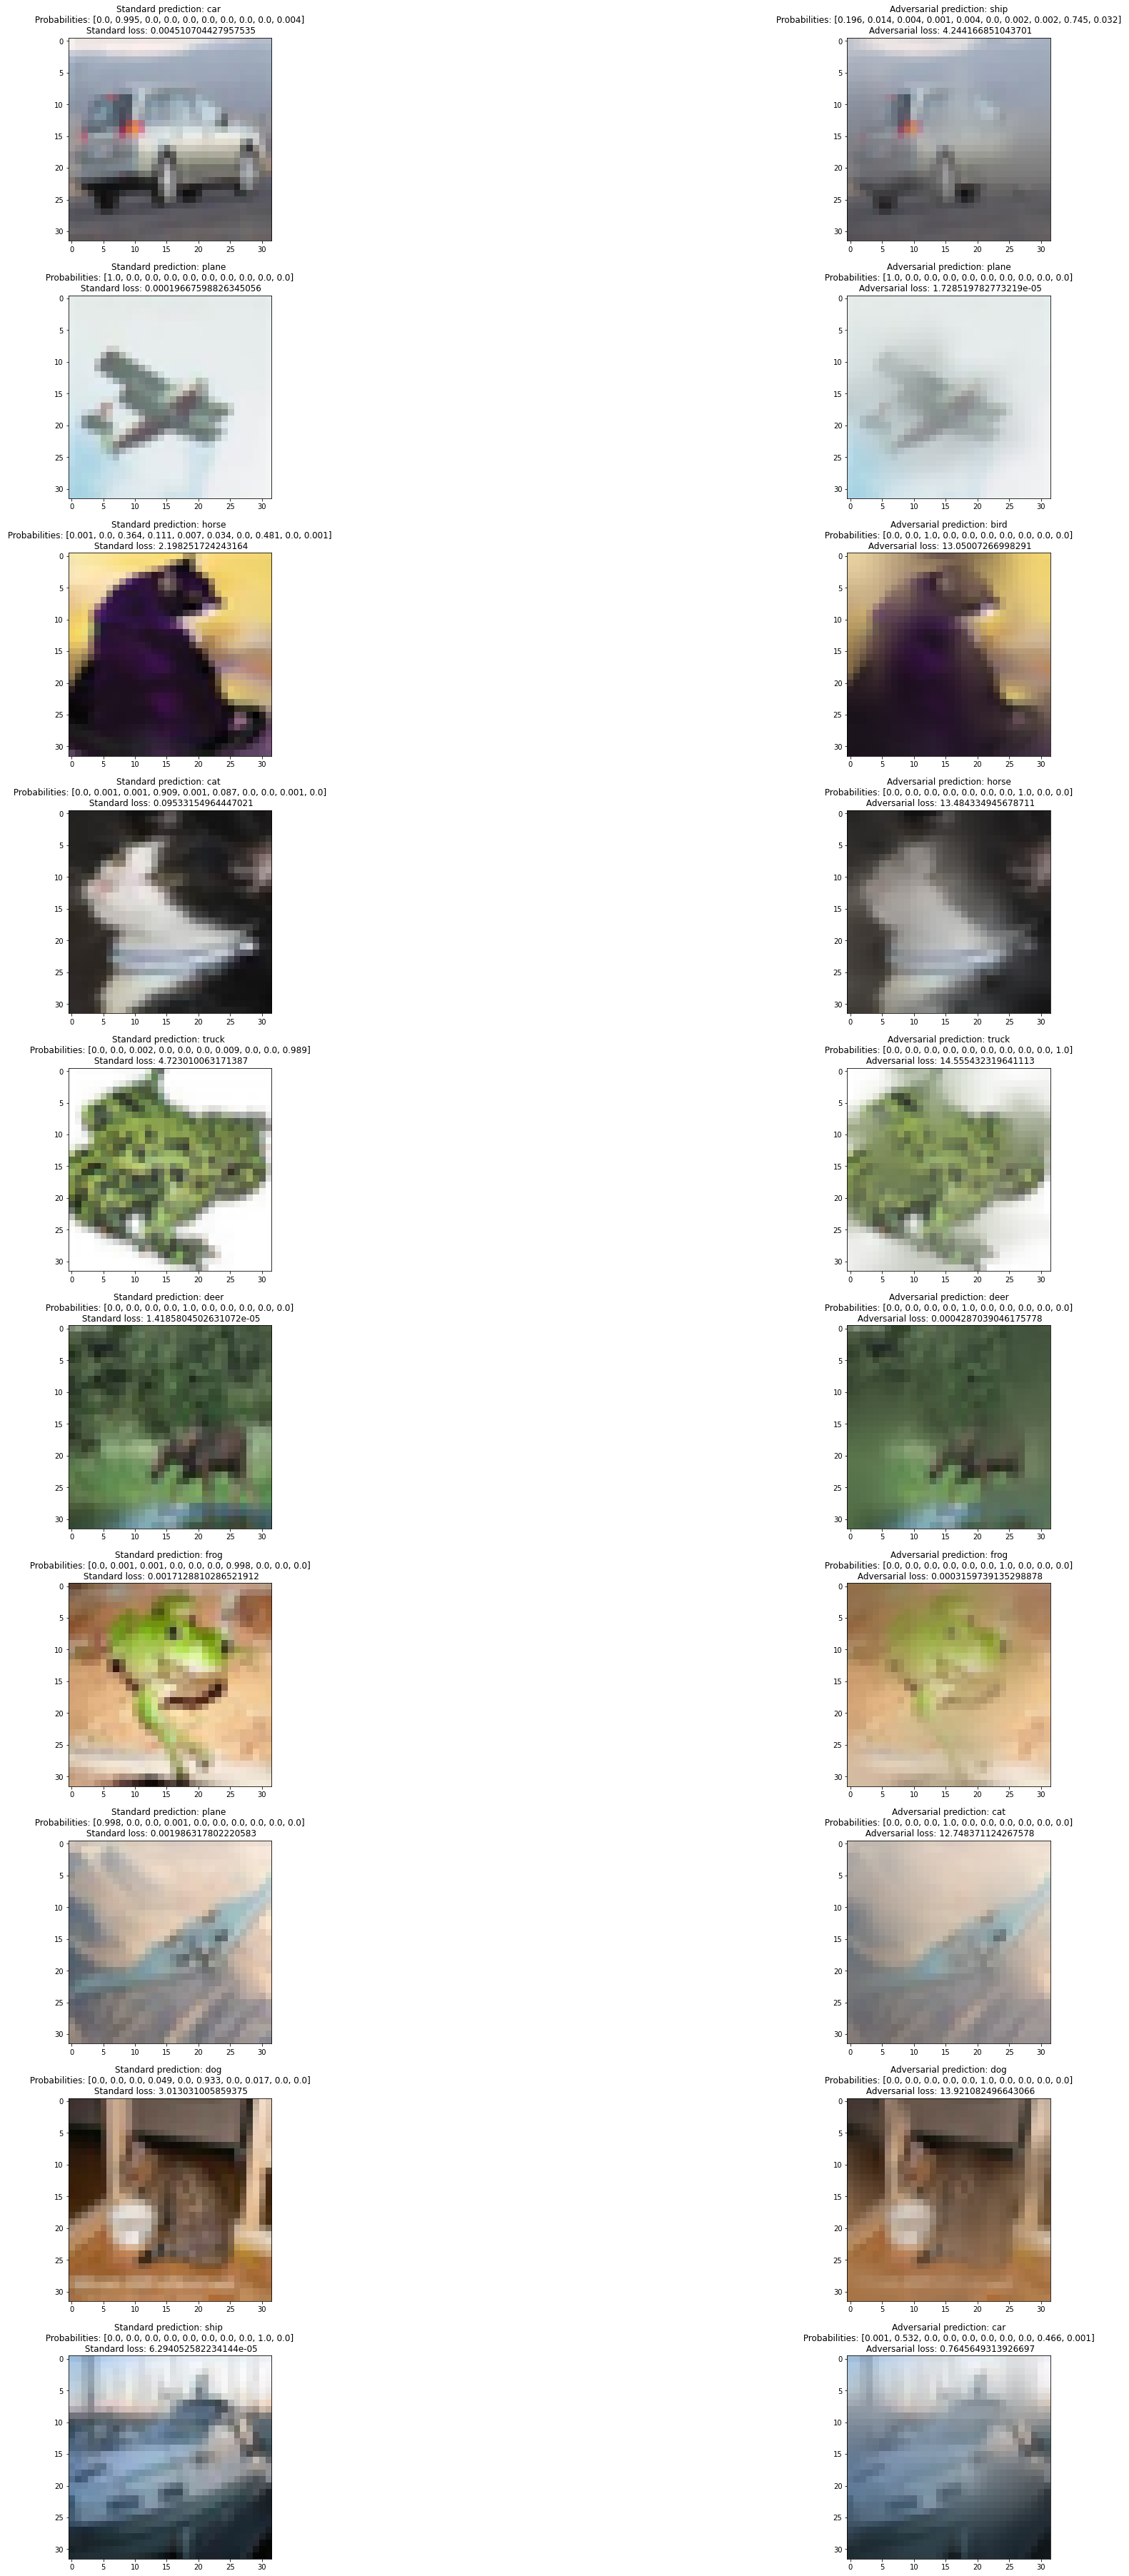

In [16]:
num_images = 10 #Number of images to be displayed
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10.pt"))
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), model)
model = model.to(DEVICE)
blur_attack = LocalBlur(model, lambda1=0.00001, mask_size=8)
dataloader = torch.utils.data.DataLoader(cifar10_test_raw, batch_size=num_images, shuffle=True)
images,labels = next(iter(dataloader))
visualise_attack(model, blur_attack, images, labels)

### Adversarial Statistics

#### CIFAR10

In [17]:
num_images = 10 #Number of images to be displayed
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), model)
blur_attack = LocalBlur(model, lambda1=0.00001, mask_size=8)
test_adv(model, blur_attack, cifar10_test_raw, nn.CrossEntropyLoss(reduce="mean"))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 20/20 [01:04<00:00,  3.22s/it]

adversarial accuracy: 11.530%


(11.53, tensor(230.3011, device='cuda:0'))

#### CIFAR100

In [18]:
num_images = 10 #Number of images to be displayed
model = resnet50(num_classes=100)
model.load_state_dict(torch.load("./save/cifar100.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]), model)
blur_attack = LocalBlur(model, lambda1=0.00001, mask_size=8)
test_adv(model, blur_attack, cifar100_test_raw, nn.CrossEntropyLoss(reduce="mean"))

100%|██████████| 20/20 [01:04<00:00,  3.21s/it]

adversarial accuracy: 3.590%


(3.59, tensor(311.2975, device='cuda:0'))

## Pullback

One common compound adversarial attack is to apply a common distortion and then further distort the image with gradient $L_p$ techniques. That is, we update the image with $\nabla_{g(x)} f_c(g(x))$, where $x$ is the original example, $f_c$ is the confidence of the correct class, and $g$ is the distortion. While this method is highly effective, one can easily train a common distortion classifier to detect this kind of attacks.

What gives the first method its power is that using $g(x)$ as input generally lowers the confidence in the prediction, which gives the gradient portion of the attack a head start. A natural idea, therefore, is to simply distort the original image $x$ with $\nabla_x f_c(g(x))$. The output confidence distribution would still be in the same brittle state, but the gradient would be pulled back to the original image. Here we demonstrate this general idea with fisheye distortion and PGD.

The input image $x$ first goes through a fisheye distortion, where pixels are relocated according to their distance to the center. A mapping between a pixel's old location and new location is constructed during the process. After we obtain the gradient on the distorted image, we apply each scalar in the gradient on the right pixel in the original image based on the mapping we constructed.

### Fisheye Distortion
Before we apply Pullback, we first establish a baseline with just fisheye distortion

In [ ]:
def get_fish_xn_yn(ij_set, radius, distortion):
    """
    Get normalized x, y pixel coordinates from the original image and return normalized 
    x, y pixel coordinates in the destination fished image.
    radius: a [32, 32] tensor, one radius for each pixel
    :param distortion: Amount in which to move pixels from/to center.
    As distortion grows, pixels will be moved further from the center, and vice versa.
    """
    same_idx = ((1 - distortion * (radius **  2)) == 0)
    denom = (1 - (distortion * (radius ** 2)))[~same_idx].unsqueeze(1)
    #print(ij_set[~same_idx].shape, denom.shape)
    ij_set[~same_idx] = ij_set[~same_idx] / denom

    return ij_set

In [ ]:
class Fisheye(Attack):

    def __init__(self, dist_coeff):
        """
        distortion_coefficient: The amount of distortion to apply.
        """
        self.dist_coeff = dist_coeff
    
    def __call__(self, img, y):
        """
        img: a torch tensor of shape [N, 3, 32, 32]
        """
        # If input image is RGB convert it to RGBA
        # So that output 'frame' can be transparent.
        h, w = img.shape[2], img.shape[3]

        # prepare array for dst image
        dstimgs = torch.zeros(img.shape) #[N, 3, 32, 32]

        # floats for calcultions
        w, h = float(w), float(h)

        x_set, y_set = torch.meshgrid(torch.arange(0, h), torch.arange(0, w), indexing="ij")
        ij_set = torch.stack([x_set, y_set], dim=2) # [h, w, 2]
        ij_set[:, :, 0] = (2 * ij_set[:, :, 0] - h) / h
        ij_set[:, :, 1] = (2 * ij_set[:, :, 1] - w) / w # standardized indices

        rd = torch.norm(ij_set, dim=2) # [h, w]

        coords_map = get_fish_xn_yn(ij_set, rd, self.dist_coeff)
        coords_map[:, :, 0] = (coords_map[:, :, 0] + 1) * h / 2
        coords_map[:, :, 1] = (coords_map[:, :, 1] + 1) * w / 2
        coords_map = torch.round(coords_map).long()
        #print(coords_map.shape)
        for x in range(dstimgs.shape[2]):
            for y in range(dstimgs.shape[3]):
                new_x, new_y = coords_map[x][y]
                if 0 <= new_x < dstimgs.shape[2] and 0 <= new_y < dstimgs.shape[3]:
                    dstimgs[:, :, x, y] = img[:, :, new_x, new_y]

        return dstimgs.to(DEVICE)

#### Baseline Statistics
With only fisheye distortion, we achieved an accuracy of 53.13% on CIFAR10 and 37.28% on CIFAR100

#### CIFAR10

In [ ]:
fisheye = Fisheye(0.8)
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), model)
test_adv(model, fisheye, cifar10_test_raw, nn.CrossEntropyLoss(reduce="mean"))

100%|██████████| 20/20 [00:02<00:00,  8.32it/s]

adversarial accuracy: 53.130%


(53.13, tensor(42.8072, device='cuda:0'))

#### CIFAR100

In [ ]:
fisheye = Fisheye(0.8)
model = resnet50(num_classes=100)
model.load_state_dict(torch.load("./save/cifar100.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]), model)
test_adv(model, fisheye, cifar100_test_raw, nn.CrossEntropyLoss(reduce="mean"))

100%|██████████| 20/20 [00:02<00:00,  8.36it/s]

adversarial accuracy: 37.280%


(37.28, tensor(61.2391, device='cuda:0'))

#### Fisheye Pullback

In [ ]:
class FisheyePullback(WhiteboxAttack):

    def __init__(self, model, dist_coeff, n_iters=10, eps=1, lr=0.1):
        """
        distortion_coefficient: The amount of distortion to apply.
        """
        self.model = model
        self.dist_coeff = dist_coeff
        self.n_iters = n_iters
        self.criterion = nn.CrossEntropyLoss(reduce="mean")
        self.eps = eps
        self.lr = lr
    
    def __call__(self, img, target):
        """
        img: a torch tensor of shape [N, 3, 32, 32]
        """
        # If input image is RGB convert it to RGBA
        # So that output 'frame' can be transparent.
        h, w = img.shape[2], img.shape[3]

        # prepare array for dst image
        dstimgs = torch.zeros(img.shape).to(DEVICE) #[N, 3, 32, 32]

        # floats for calcultions
        w, h = float(w), float(h)

        x_set, y_set = torch.meshgrid(torch.arange(0, h), torch.arange(0, w), indexing="ij")
        ij_set = torch.stack([x_set, y_set], dim=2) # [h, w, 2]
        ij_set[:, :, 0] = (2 * ij_set[:, :, 0] - h) / h
        ij_set[:, :, 1] = (2 * ij_set[:, :, 1] - w) / w # standardized indices

        rd = torch.norm(ij_set, dim=2) # [h, w]
        coords_map = get_fish_xn_yn(ij_set, rd, self.dist_coeff)
        coords_map[:, :, 0] = (coords_map[:, :, 0] + 1) * h / 2
        coords_map[:, :, 1] = (coords_map[:, :, 1] + 1) * w / 2
        coords_map = torch.round(coords_map).long()

        for x in range(dstimgs.shape[2]):
            for y in range(dstimgs.shape[3]):
                new_x, new_y = coords_map[x][y]
                if 0 <= new_x < dstimgs.shape[2] and 0 <= new_y < dstimgs.shape[3]:
                    dstimgs[:, :, x, y] = img[:, :, new_x, new_y]
        

        adv_fisheye = dstimgs.clone().detach().to(DEVICE)

        for i in range(self.n_iters):
            adv_fisheye.requires_grad = True
            logits = self.model(adv_fisheye)
            model.zero_grad()
            loss = self.criterion(logits, target)
            loss.backward()
            grad = adv_fisheye.grad
            delta = torch.clamp(self.lr * grad, min=-self.eps, max=self.eps)
            adv_imgs = torch.clamp(adv_fisheye + delta, min=0, max=1).detach_()
        
        delta = adv_fisheye - dstimgs #[N, 3, 32, 32]
        adv_imgs = img.clone()
        for x in range(dstimgs.shape[2]):
            for y in range(dstimgs.shape[3]):
                new_x, new_y = coords_map[x][y]
                if 0 <= new_x < dstimgs.shape[2] and 0 <= new_y < dstimgs.shape[3]:
                    adv_imgs[:, :, new_x, new_y] += delta[:, :, x, y]
        adv_imgs = adv_imgs.clamp(min=0, max=1)
        return adv_imgs.detach().to(DEVICE)

### Visualization
Looks indistinguishable!

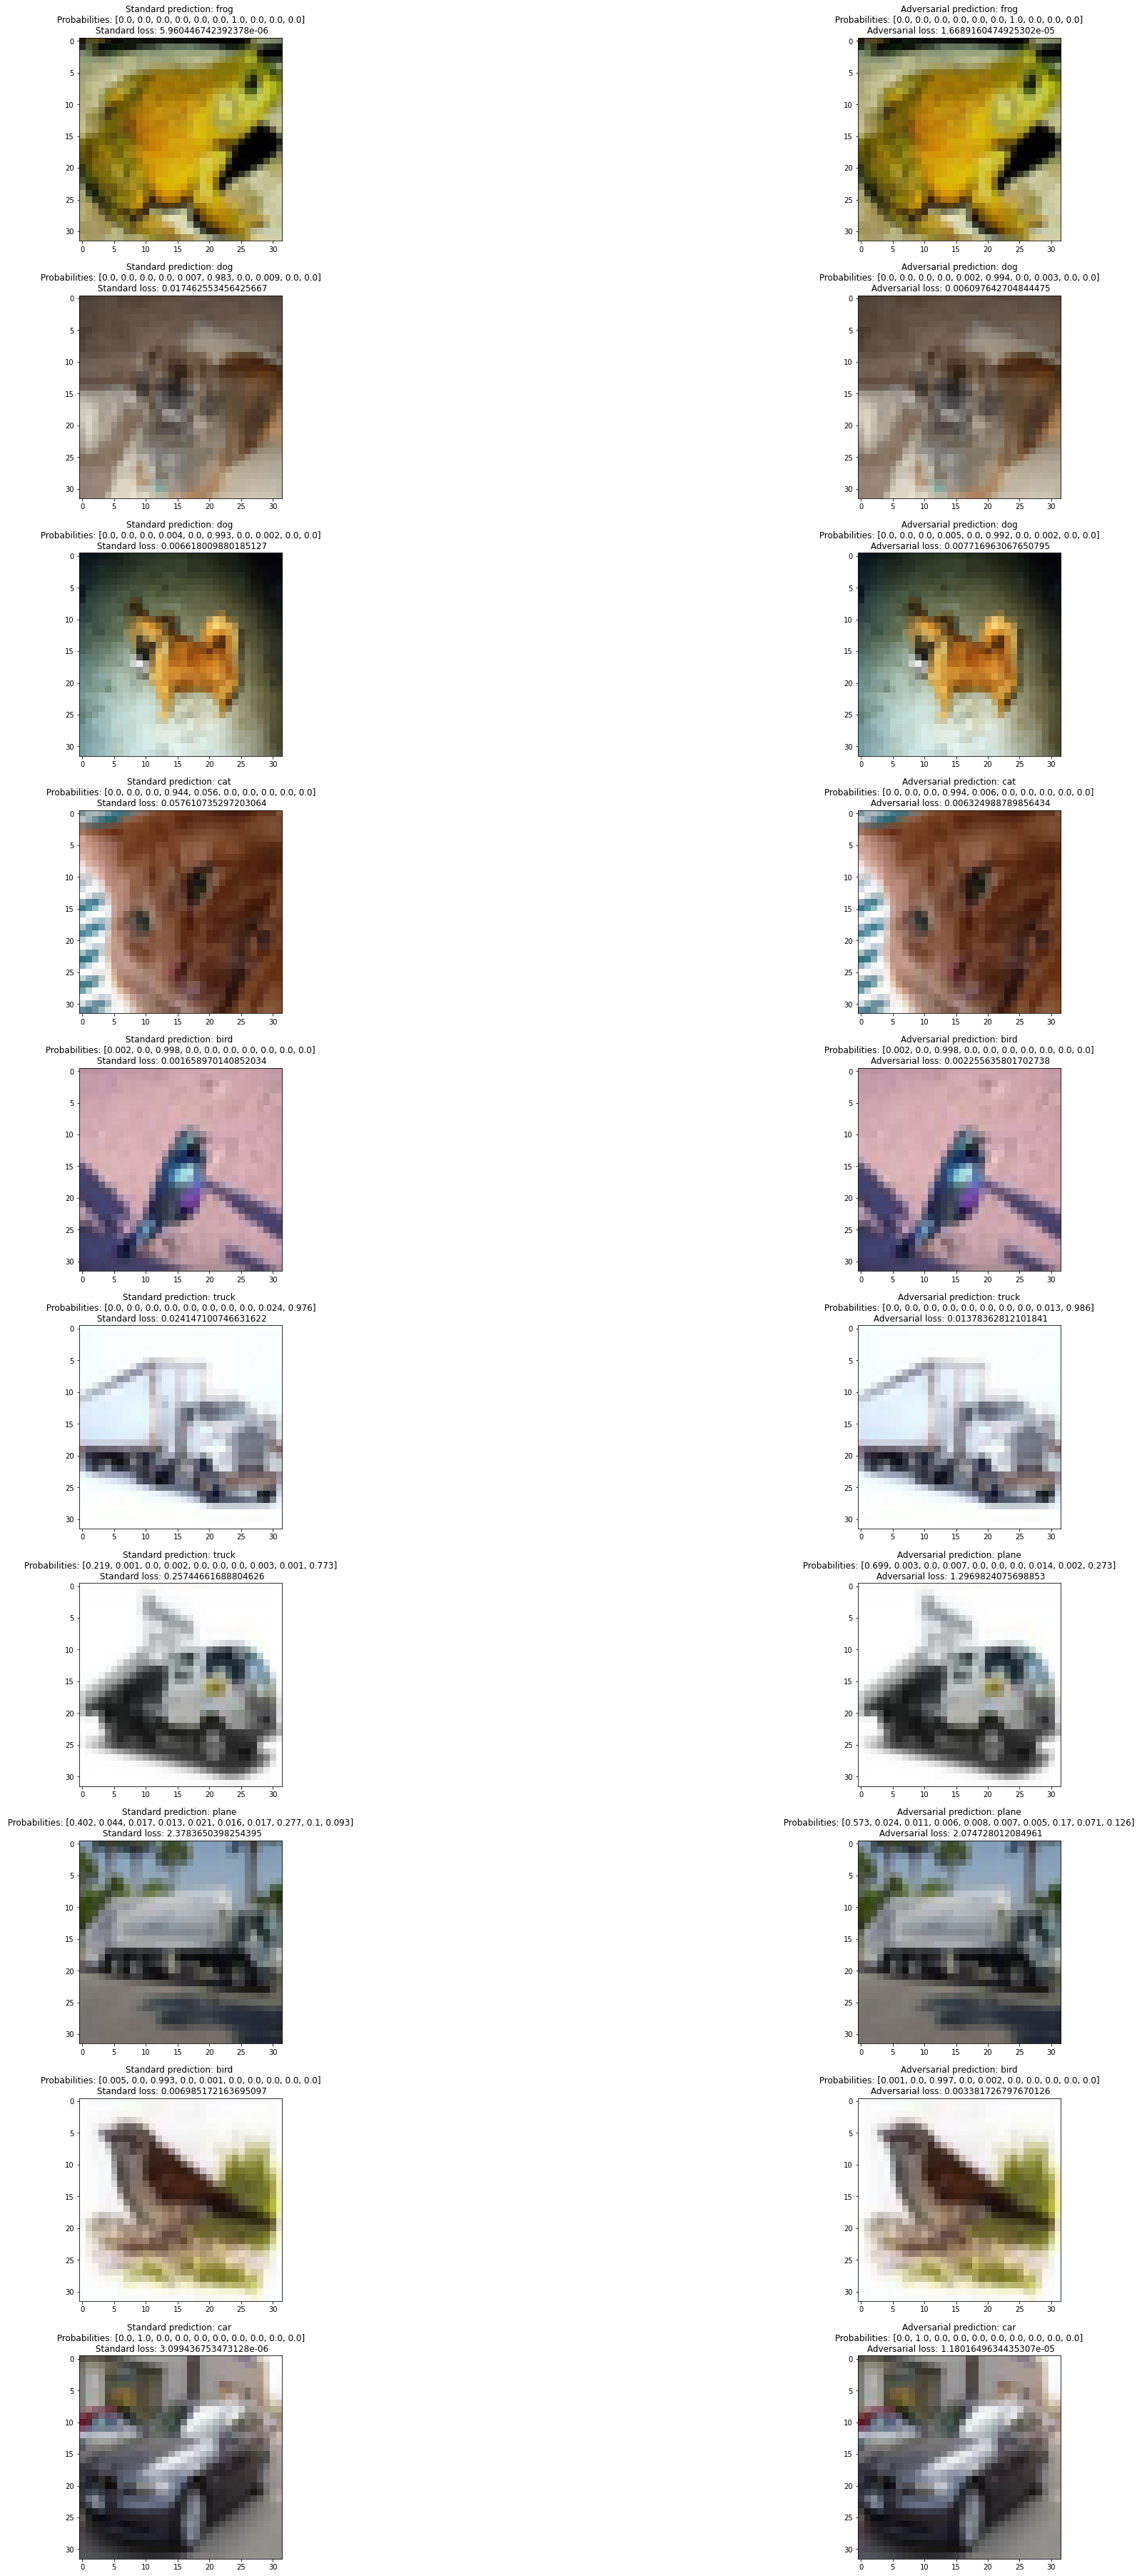

In [ ]:
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), model)
fisheye = FisheyePullback(model, 0.8)
dataloader = torch.utils.data.DataLoader(cifar10_test_raw, batch_size=num_images, shuffle=True)
images, labels = next(iter(dataloader))
visualise_attack(model, fisheye, images, labels)

### Adversarial Statistics

#### CIFAR10

In [ ]:
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10.pt"))
model = model.to(DEVICE)
fisheye = FisheyePullback(model, 0.8)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), model)
test_adv(model, fisheye, cifar10_test, nn.CrossEntropyLoss(reduce="mean"))

100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

adversarial accuracy: 35.590%


(35.59, tensor(82.2404, device='cuda:0'))

In [ ]:
model = resnet50(num_classes=100)
model.load_state_dict(torch.load("./save/cifar100.pt"))
model = model.to(DEVICE)
fisheye = FisheyePullback(model, 0.8)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]), model)
test_adv(model, fisheye, cifar100_test, nn.CrossEntropyLoss(reduce="mean"))

100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

adversarial accuracy: 15.070%


(15.07, tensor(111.8271, device='cuda:0'))

## $\mu$-$\delta$ Attack
When we tinkered with different ideas, we observed that neural networks are sensitive to their normalization hyperparameters. In the case of CIFAR datasets, we normalize each channel of the image with a mean and standard deviation.

The  $\mu$-$\delta$ attack has two parameters $\hat{\mu} \in \mathbb{R}^3$ and $\hat{\delta} \in \mathbb{R}^3$. Suppose $x$ is an unnormalized input image. The objective of the $\mu$-$\delta$ attack is

$$ \min_{\hat{\mu}, \hat{\delta}} \mathbb{E}_{x \in \mathcal{X}} \left[ f_c\left( \frac{x - (\mu + \hat{\mu})}{\delta + \hat{\delta}} \right) \right], $$
where $f_c$ is the confidence of the correct class; $\mu$ and $\delta$ are the empirical mean and standard deviation of the data. Note that unlike conventional attacks, where the gradient is computed based on one example, $\hat{\mu}$ and $\hat{\delta}$ are estimated across a distribution $\mathcal{X}$. In practice, the attacker can optimize $\hat{\mu}$ and $\hat{\delta}$ on a dataset sampled from the sample population as the data the model is trained on.

To ensure that we do not alter the semantics of the input images, we cap $|\hat{\mu}|$ and $|\hat{\delta}|$ with fixed values $\epsilon_\mu$ and $\epsilon_\delta$ respectively.

In [ ]:
class MuDelta(WhiteboxAttack):

    def __init__(self, model, mean, sd, eps1=0.2, eps2=0.1, step_size=0.1, n_iters=10):
        """
        mean: the empirical mean of the data
        sd: the empirical standard deviation
        eps1: magnitude cap for dmean
        eps2: magnitude cap for dsd
        """

        self.model = model
        self.mean = torch.tensor(mean).to(DEVICE)
        self.sd = torch.tensor(sd).to(DEVICE)
        self.eps1 = eps1
        self.eps2 = eps2
        self.lr = step_size
        self.n_iters = n_iters
        self.dmean = None
        self.dsd = None
    
    def fit(self, dataset):
        """
        CAUTION: img should be unstandardized
        """
        dmean = torch.zeros((3, )).to(DEVICE)
        dsd = torch.zeros((3, )).to(DEVICE)

        loader = DataLoader(dataset, batch_size=128,
                            shuffle=True, num_workers=2)
        
        for i in range(self.n_iters):
            for i, data in enumerate(tqdm(loader), 0):
                img, labels = data
                img, labels = img.to(DEVICE), labels.to(DEVICE)
                dmean.requires_grad = True
                dsd.requires_grad = True
                mu = self.mean + dmean
                sd = self.sd + dsd
                img = torchvision.transforms.functional.normalize(img, mean=mu, std=sd)
                logits = self.model(img)
                loss = F.cross_entropy(logits, labels)
                loss.backward(retain_graph=True)
                mu_grad = dmean.grad
                sd_grad = dsd.grad

                dmean = torch.clamp(dmean + self.lr * mu_grad, min=-self.eps1, max=self.eps1).detach()
                dsd = torch.clamp(dsd + self.lr * sd_grad, min=-self.eps2, max=self.eps2).detach()
                #print(dmean, dsd)
        
        self.dmean = dmean.detach()
        self.dsd = dsd.detach()
        
    def __call__(self, img, labels):
        if self.dmean is None or self.dsd is None:
            assert False, "dmean or dsd not calculated"
        mu = self.mean + self.dmean
        sd = self.sd + self.dsd
        adv_img = torchvision.transforms.functional.normalize(img, mean=mu, std=sd)
        adv_img = torch.clamp(adv_img, min=0, max=1).detach()
        return adv_img



In [ ]:
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10.pt"))
model = model.to(DEVICE)
mudelta10 = MuDelta(model, 
                    mean=[0.4914, 0.4822, 0.4465],
                    sd=[0.247, 0.243, 0.261],
                    eps1=0.01,
                    eps2=0.01,
                    n_iters=1)
mudelta10.fit(cifar10_test_raw)

100%|██████████| 79/79 [00:07<00:00, 10.89it/s]


Let's take a look at the $\hat{\mu}$ and $\hat{\delta}$ we've learnt.

In [ ]:
mudelta10.dmean, mudelta10.dsd

(tensor([0.0100, 0.0091, 0.0009], device='cuda:0'),
 tensor([-0.0100,  0.0100,  0.0057], device='cuda:0'))

#### Visualization

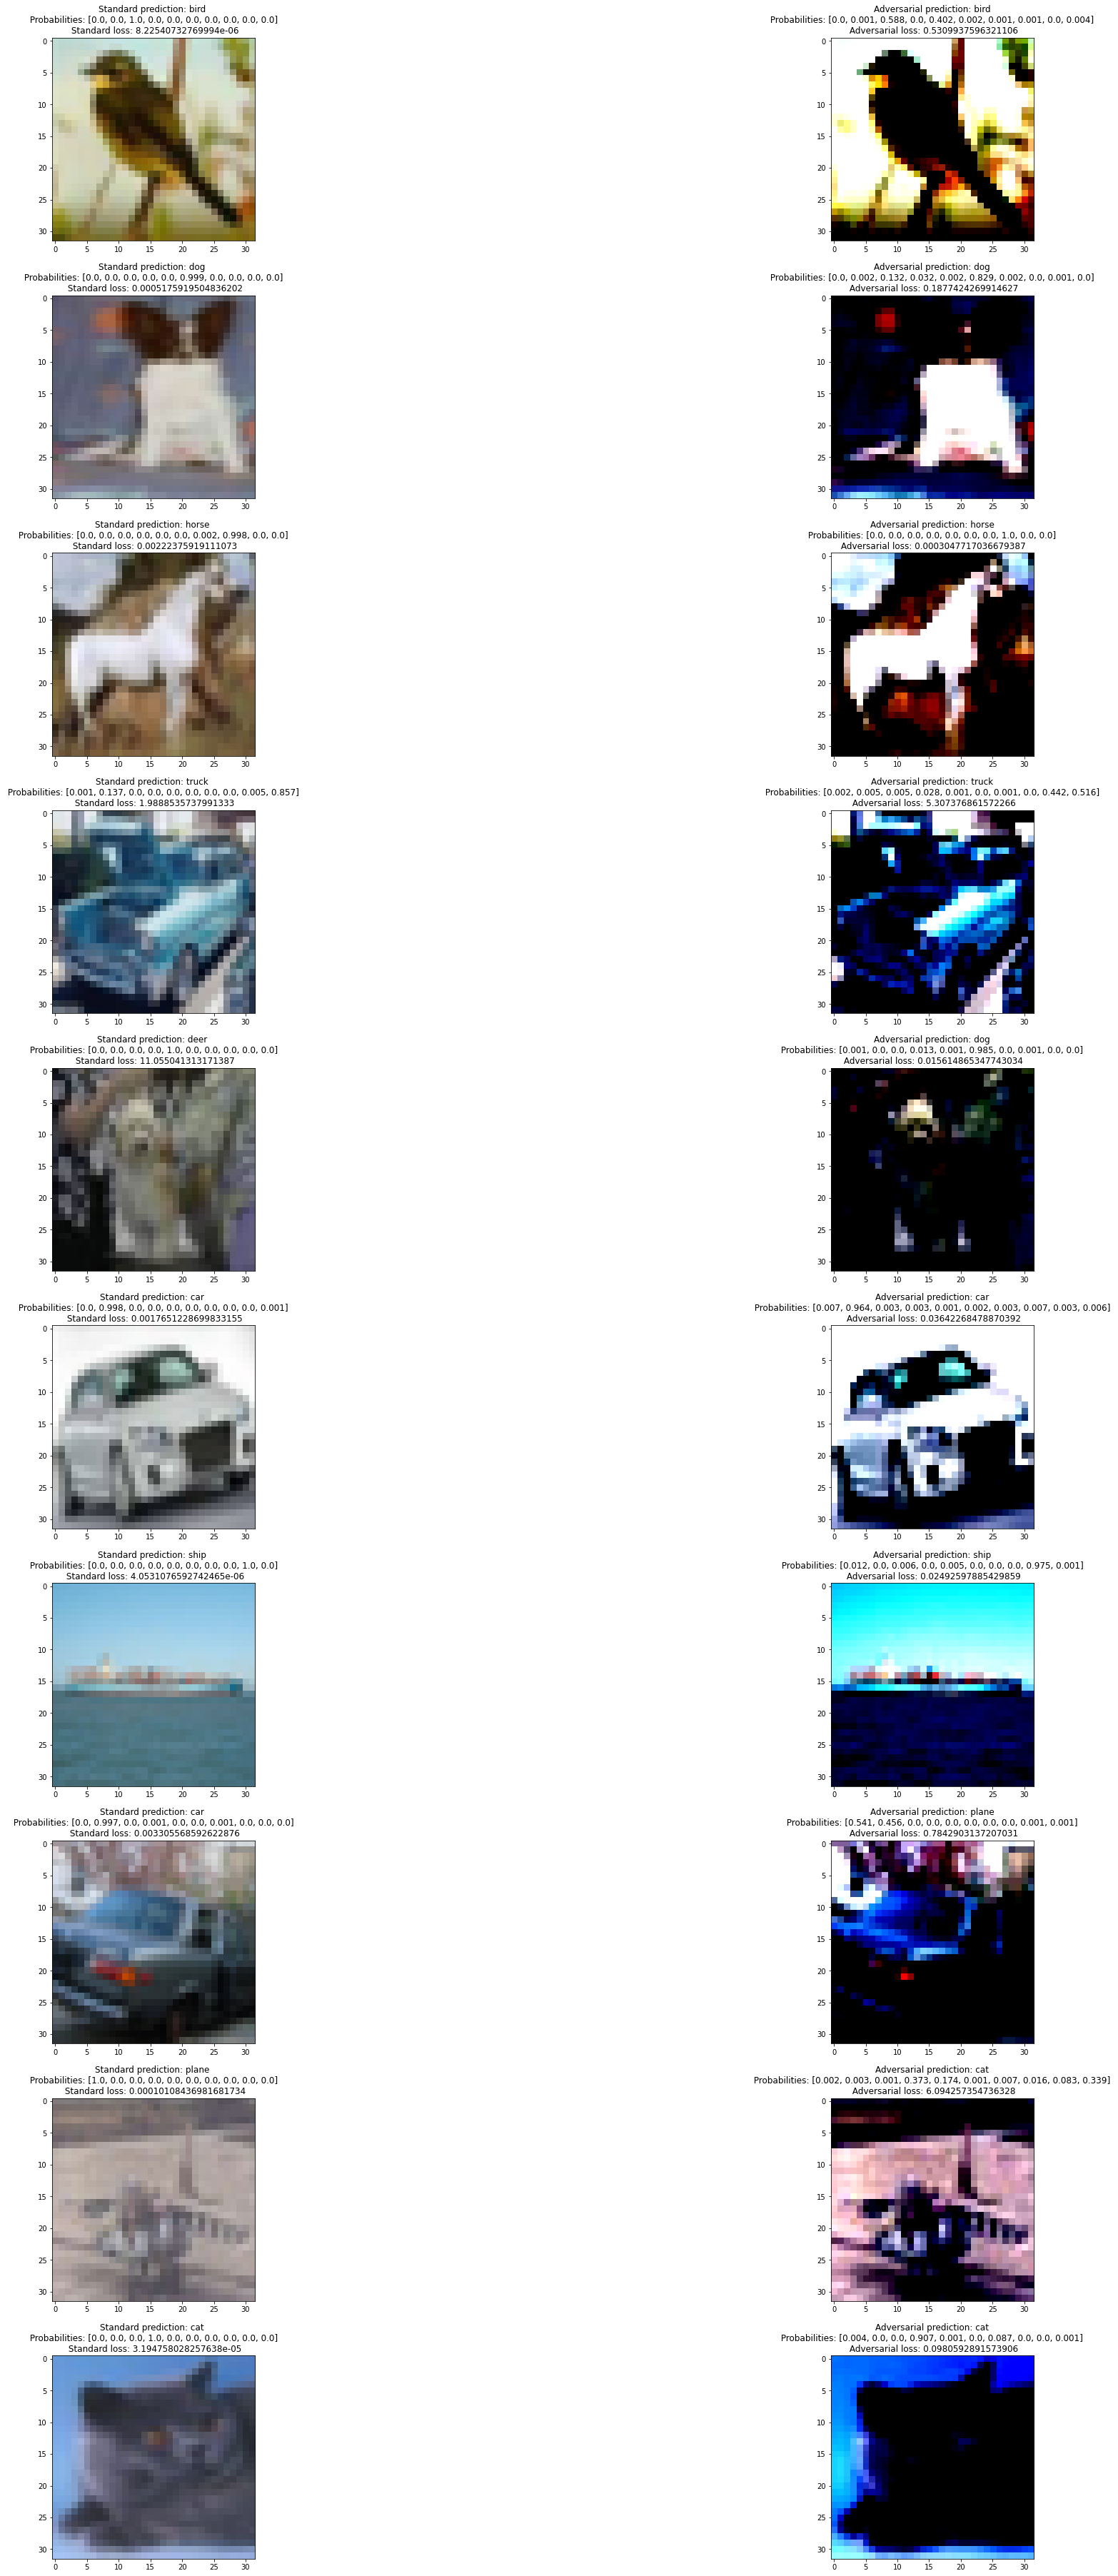

In [ ]:
num_images = 10
dataloader = torch.utils.data.DataLoader(cifar10_test_raw, batch_size=num_images, shuffle=True)
images, labels = next(iter(dataloader))
visualise_attack(model, mudelta10, images, labels)

#### CIFAR10 Statistics
Not as good as the other attacks but there were only 6 parameters to learn!

In [ ]:
test_adv(model, mudelta10, cifar10_test_raw, nn.CrossEntropyLoss(reduce="mean"))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 20/20 [00:02<00:00,  7.43it/s]

adversarial accuracy: 53.410%


(53.41, tensor(49.3635, device='cuda:0'))

### CIFAR100

In [ ]:
model = resnet50(num_classes=100)
model.load_state_dict(torch.load("./save/cifar100.pt"))
model = model.to(DEVICE)
mudelta100 = MuDelta(model, 
                     mean=[0.507, 0.487, 0.441], 
                     sd=[0.267, 0.256, 0.276],
                     eps1=0.01,
                     eps2=0.01,
                     n_iters=1)
mudelta100.fit(cifar100_test_raw)

100%|██████████| 79/79 [00:10<00:00,  7.70it/s]


In [ ]:
mudelta100.dmean, mudelta100.dsd

(tensor([-0.0100,  0.0093,  0.0100], device='cuda:0'),
 tensor([-0.0100,  0.0100, -0.0100], device='cuda:0'))

#### CIFAR100 Statistics
Same as CIFAR10. Not as potent as other attacks but definitely effective.

In [ ]:
test_adv(model, mudelta100, cifar100_test_raw, nn.CrossEntropyLoss(reduce="mean"))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 20/20 [00:02<00:00,  8.68it/s]

adversarial accuracy: 22.930%


(22.93, tensor(110.7454, device='cuda:0'))

## Adversarial Training

Would fine-tuning the model on adversarial examples improve the model's adversarial accuracy? In this section, we fine-tuning our trained model on adversarial examples generated from the training sets of CIFAR10 and CIFAR100. Each training set is split in two halves: one half to generate LocalBlur adversarial examples and the other to generate Pullback adversarial examples.

For both CIFAR10 and CIFAR100, adversarial fine-tuning decreased the adversarial accuracy. Both LocalBlur and Fisheye Pullback achieved an adversarial accuracy of 10% on CIFAR10 and 1% on CIFAR100. We hypothesize that even when we train the model to recognize **existed** adversarial examples, whitebox attacks such as LocalBlur and Fisheye Pullback can still find vulnerabilities on the optimization surface.

We did not include $\mu$-$\delta$ attack, because we came up with attack a few hours before the deadline. Thus, we did not have to implement the corresponding adversarial training.

In [ ]:
def generate_adv_examples(out_path, dataset, model):
    """
    CAUTION: dataset should be unstandardized, and model should be a nn.Sequential(Normalize(), model)
    """
    fisheye = FisheyePullback(model, 0.8)
    localblur = LocalBlur(model, lambda1=0.00001, mask_size=8)
    size1, size2 = len(dataset) // 2, len(dataset) - len(dataset) // 2
    fisheye_dataset, localblur_dataset = torch.utils.data.random_split(dataset, [size1, size2])

    adv_examples = []
    Y = []

    for loader_name in ["localblur", "fisheye"]:
        if loader_name == "fisheye":
            loader = torch.utils.data.DataLoader(fisheye_dataset, batch_size=512,
                                                 shuffle=True, num_workers=2)
        else:
            loader = torch.utils.data.DataLoader(localblur_dataset, batch_size=512,
                                                 shuffle=True, num_workers=2)
        for i, data in enumerate(tqdm(loader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            if loader_name == "localblur":
                adv_inputs = localblur(inputs, labels)
            else:
                adv_inputs = fisheye(inputs, labels)
            adv_examples.append(adv_inputs)
            Y.append(labels)
    

    adv_examples = torch.cat(adv_examples, dim=0).cpu().detach() # should be a [N, 3, 32, 32] tensor
    labels = torch.cat(Y, dim=0).cpu().detach()
    print(adv_examples.shape, labels.shape)
    torch.save({"img": adv_examples, "label": labels}, out_path)
    
    

### Generating the Adversarial Dataset

In [ ]:
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), model)
generate_adv_examples("./data/adv10.pt", cifar10_train_raw, model)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 49/49 [02:41<00:00,  3.29s/it]


torch.Size([50000, 3, 32, 32]) torch.Size([50000])


In [ ]:
model = resnet50(num_classes=100)
model.load_state_dict(torch.load("./save/cifar100.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]), model)
generate_adv_examples("./data/adv100.pt", cifar100_train_raw, model)

100%|██████████| 49/49 [02:41<00:00,  3.29s/it]


torch.Size([50000, 3, 32, 32]) torch.Size([50000])


### Fine-tuning

First, we define a custom `Dataset` class to represent our adversarial data.

In [ ]:
class AdvDataset(Dataset):

    def __init__(self, data):
        """
        data: a [N, 3, 32, 32] tensor
        """

        self.data = data
    
    def __getitem__(self, index):
        return self.data["img"][index], self.data["label"][index]
    
    def __len__(self):
        return self.data["img"].shape[0]

We also define a `train_adv` function for adversarial fine-tuning.

In [ ]:
def train_adv(model, train_data, valid_data, batch_size=128, n_epochs=100, lr=1e-3, scheduler=None):
    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']
    
    print("Initializing...\n")
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=5e-4)
    if scheduler == "multistep":
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 100, 120], gamma=0.2)
    criterion = torch.nn.CrossEntropyLoss()

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    print("Training...\n")
    model.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print("Learning Rate: {}".format(get_lr(optimizer)))

        running_loss = 0.
        for i, data in enumerate(tqdm(trainloader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.cpu().item()
            if i % 200 == 199:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 90:.3f}')
                running_loss = 0.0

        #print("Epoch {} VALIDATION ACCURACY: {:.5f}".format(epoch, acc))
        #print("Epoch {} VALIDATION LOSS: {:.5f}".format(epoch, valid_loss))

        if scheduler is not None:
            scheduler.step()


    return model

#### CIFAR10

First, we finetune the CIFAR10 model on the adversarial dataset for 60 epochs with 0.001 learning rate.

In [ ]:
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), model)
cifar10_adv = AdvDataset(torch.load("./data/adv10.pt"))
trained_model = train_adv(model, cifar10_adv, cifar10_test_raw, batch_size=128, n_epochs=60, lr=0.001)
torch.save(model.state_dict(), './save/cifar10_adv.pt')

Now, let's test it on the CIFAR10 test set under LocalBlur attack

In [ ]:
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10_adv.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), model)
localblur = LocalBlur(model, lambda1=0.00001, mask_size=8)
test_adv(model, localblur, cifar10_test_raw, nn.CrossEntropyLoss(reduction="mean"))

100%|██████████| 20/20 [01:05<00:00,  3.28s/it]

adversarial accuracy: 10.000%


(10.0, tensor(46.0669, device='cuda:0'))

What about Fisheye Pullback?

In [ ]:
model = resnet50(num_classes=10)
model.load_state_dict(torch.load("./save/cifar10_adv.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), model)
fisheye = FisheyePullback(model, 0.8)
test_adv(model, fisheye, cifar10_test_raw, nn.CrossEntropyLoss(reduction="mean"))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 20/20 [01:06<00:00,  3.33s/it]

adversarial accuracy: 10.000%


(10.0, tensor(46.0438, device='cuda:0'))

#### CIFAR100

Likewise, we train the CIFAR100 model on adversarial examples.

In [ ]:
model = resnet50(num_classes=100)
model.load_state_dict(torch.load("./save/cifar100.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]), model)
cifar100_adv = AdvDataset(torch.load("./data/adv100.pt"))
trained_model = train_adv(model, cifar100_adv, cifar10_test_raw, batch_size=128, n_epochs=60, lr=0.001)
torch.save(model.state_dict(), './save/cifar100_adv.pt')

LocalBLur

In [ ]:
model = resnet50(num_classes=100)
model.load_state_dict(torch.load("./save/cifar100_adv.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]), model)
localblur = LocalBlur(model, lambda1=0.00001, mask_size=8)
test_adv(model, localblur, cifar100_test_raw, nn.CrossEntropyLoss(reduction="mean"))

100%|██████████| 20/20 [01:05<00:00,  3.27s/it]

adversarial accuracy: 1.000%


(1.0, tensor(92.1222, device='cuda:0'))

In [ ]:
model = resnet50(num_classes=100)
model.load_state_dict(torch.load("./save/cifar100_adv.pt"))
model = model.to(DEVICE)
model = torch.nn.Sequential(torchvision.transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]), model)
fisheye = FisheyePullback(model, 0.8)
test_adv(model, localblur, cifar100_test_raw, nn.CrossEntropyLoss(reduction="mean"))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 20/20 [01:05<00:00,  3.27s/it]

adversarial accuracy: 1.000%


(1.0, tensor(92.1230, device='cuda:0'))